In [1]:
# %% [Cell 1] Imports and Configuration for DPU Execution
from pynq_dpu import DpuOverlay
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

# Load DPU overlay and model
overlay = DpuOverlay("dpu.bit")
overlay.load_model("./compiled_model/compiled_resnet50_grocery.xmodel")

# Define label names
labelNames_list = ["Apple", "Juice", "Melon", "Milk", "Pear", "Pepper", "Tomato", "Yoghurt"]
labelNames_dict = {name: i for i, name in enumerate(labelNames_list)}

In [7]:
# %% [Cell 2] Preprocessing, DPU Execution, and Postprocessing Functions
from collections import namedtuple

def preprocess_fn(image, target_height=224, target_width=224):
    start_time = time.time()
    image = cv2.resize(image, (target_width, target_height))  # Resize image
    image = image / 255.0  # Normalize image
    end_time = time.time()
    return image, end_time - start_time

def dpu_execute_fn(preprocessed_image, dpu_config):
    start_time = time.time()
    dpu_config.input_data[0][0, ...] = preprocessed_image.reshape(dpu_config.shape_in[1:])
    job_id = dpu_config.dpu.execute_async(dpu_config.input_data, dpu_config.output_data)
    dpu_config.dpu.wait(job_id)
    end_time = time.time()
    return dpu_config.output_data, end_time - start_time

def postprocess_fn(output_data, output_size):
    start_time = time.time()
    temp = [j.reshape(1, output_size) for j in output_data]
    softmax = np.exp(temp[0][0])
    softmax = softmax / np.sum(softmax)
    end_time = time.time()
    return softmax, end_time - start_time

# Prepare DPU runner
dpu = overlay.runner
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()
shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]

# Create an immutable configuration object
DPUConfig = namedtuple('DPUConfig', ['dpu', 'shape_in', 'shape_out', 'output_size', 'input_data', 'output_data'])
dpu_config = DPUConfig(dpu, shapeIn, shapeOut, outputSize, input_data, output_data)

def run(image_path):
    original_image = cv2.imread(image_path)
    preprocessed, preprocess_time = preprocess_fn(original_image)
    output_data, dpu_time = dpu_execute_fn(preprocessed, dpu_config)
    softmax, postprocess_time = postprocess_fn(output_data, dpu_config.output_size)
    
    total_time = preprocess_time + dpu_time + postprocess_time
    
    return softmax, preprocess_time, dpu_time, postprocess_time, total_time

print(f"DPU Configuration: shape_in={dpu_config.shape_in}, shape_out={dpu_config.shape_out}, output_size={dpu_config.output_size}")

DPU Configuration: shape_in=(1, 224, 224, 3), shape_out=(1, 1, 1, 8), output_size=8


In [8]:
# %% [Cell 3] Load Test Dataset and Evaluation
# Set test image folder path
test_image_folder = 'grocery_store_dataset/new/test'
categories = os.listdir(test_image_folder)
test_images = []
test_labels = []

# Load image file paths and labels
for category in categories:
    category_folder = os.path.join(test_image_folder, category)
    images = [os.path.join(category_folder, img) for img in os.listdir(category_folder) if img.endswith((".jpg", ".jpeg", ".png"))]
    test_images.extend(images)
    test_labels.extend([category] * len(images))

total_images = len(test_images)
print(f"Total images loaded: {total_images}")

# Evaluate the model
correct_predictions = 0
predicted_labels = []
preprocess_times = []
dpu_times = []
postprocess_times = []
total_times = []
start_time = time.time()

for image_path, label in zip(test_images, test_labels):
    softmax, preprocess_time, dpu_time, postprocess_time, total_time = run(image_path)
    predicted_label = labelNames_list[np.argmax(softmax)]
    predicted_labels.append(predicted_label)
    if predicted_label == label:
        correct_predictions += 1
    
    preprocess_times.append(preprocess_time)
    dpu_times.append(dpu_time)
    postprocess_times.append(postprocess_time)
    total_times.append(total_time)

end_time = time.time()
accuracy = correct_predictions / total_images
average_fps = total_images / (end_time - start_time)
average_preprocess_time = np.mean(preprocess_times)
average_dpu_time = np.mean(dpu_times)
average_postprocess_time = np.mean(postprocess_times)
average_total_time = np.mean(total_times)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Average FPS: {average_fps:.2f}")
print(f"Average Preprocess Time: {average_preprocess_time * 1000:.2f} ms")
print(f"Average DPU Time: {average_dpu_time * 1000:.2f} ms")
print(f"Average Postprocess Time: {average_postprocess_time * 1000:.2f} ms")
print(f"Average Total Time: {average_total_time * 1000:.2f} ms")

Total images loaded: 176
Accuracy: 99.43%
Average FPS: 40.57
Average Preprocess Time: 4.56 ms
Average DPU Time: 16.66 ms
Average Postprocess Time: 0.23 ms
Average Total Time: 21.45 ms


Confusion Matrix:
[[21  0  1  0  0  0  0  0]
 [ 0 22  0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  0]
 [ 0  0  0 22  0  0  0  0]
 [ 0  0  0  0 22  0  0  0]
 [ 0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 22  0]
 [ 0  0  0  0  0  0  0 22]]
Apple:
 Precision: 100.00%
 Recall: 95.45%
 F1-score: 97.67%
Juice:
 Precision: 100.00%
 Recall: 100.00%
 F1-score: 100.00%
Melon:
 Precision: 95.65%
 Recall: 100.00%
 F1-score: 97.78%
Milk:
 Precision: 100.00%
 Recall: 100.00%
 F1-score: 100.00%
Pear:
 Precision: 100.00%
 Recall: 100.00%
 F1-score: 100.00%
Pepper:
 Precision: 100.00%
 Recall: 100.00%
 F1-score: 100.00%
Tomato:
 Precision: 100.00%
 Recall: 100.00%
 F1-score: 100.00%
Yoghurt:
 Precision: 100.00%
 Recall: 100.00%
 F1-score: 100.00%


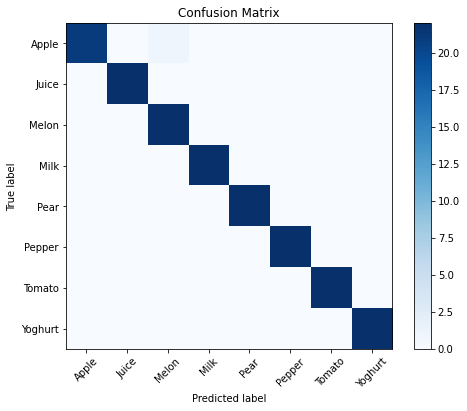

In [9]:
# %% [Cell 4] Print Classification Results and Metrics
# Calculate confusion matrix
conf_matrix = np.zeros((len(labelNames_list), len(labelNames_list)), dtype=int)

for actual, predicted in zip(test_labels, predicted_labels):
    actual_idx = labelNames_dict[actual]
    predicted_idx = labelNames_dict[predicted]
    conf_matrix[actual_idx, predicted_idx] += 1

print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1-score
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for idx, label in enumerate(labelNames_list):
    print(f"{label}:")
    print(f" Precision: {precision[idx] * 100:.2f}%")
    print(f" Recall: {recall[idx] * 100:.2f}%")
    print(f" F1-score: {f1_score[idx] * 100:.2f}%")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labelNames_list))
plt.xticks(tick_marks, labelNames_list, rotation=45)
plt.yticks(tick_marks, labelNames_list)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Recognized: Tomato
Preprocess Time: 4.66 ms
DPU Time: 17.16 ms
Postprocess Time: 0.35 ms
Total Time: 22.17 ms
Annotated image saved as webcam/Tomato_2.jpg


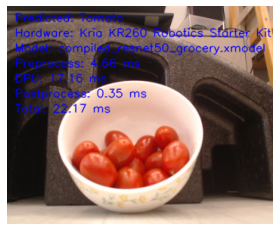

In [42]:
# %% [Cell 5] Webcam Image Capture and Inference

# Capture image from webcam
!mkdir -p webcam
!fswebcam --no-banner --save 'webcam/webcam.jpg' -d /dev/video0 2> /dev/null

# Run inference on captured image
webcam_image_path = 'webcam/webcam.jpg'
softmax, preprocess_time, dpu_time, postprocess_time, total_time = run(webcam_image_path)
predicted_label = labelNames_list[np.argmax(softmax)]

# If no object is recognized, set the label to "Unknown"
if np.max(softmax) < 0.5:
    predicted_label = "Unknown"

# Print recognized label and times
print(f"Recognized: {predicted_label}")
print(f"Preprocess Time: {preprocess_time * 1000:.2f} ms")
print(f"DPU Time: {dpu_time * 1000:.2f} ms")
print(f"Postprocess Time: {postprocess_time * 1000:.2f} ms")
print(f"Total Time: {total_time * 1000:.2f} ms")

# Load the image to add text
image = cv2.imread(webcam_image_path)
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5  # Smaller font scale
font_color = (255, 0, 0)
font_thickness = 1

# Text to add to image
text = f"Predicted: {predicted_label}"
hardware_info = "Hardware: Kria KR260 Robotics Starter Kit"
model_info = "Model: compiled_resnet50_grocery.xmodel"
preprocess_info = f"Preprocess: {preprocess_time * 1000:.2f} ms"
dpu_time_info = f"DPU: {dpu_time * 1000:.2f} ms"
postprocess_info = f"Postprocess: {postprocess_time * 1000:.2f} ms"
total_info = f"Total: {total_time * 1000:.2f} ms"

# Add text to the image
cv2.putText(image, text, (10, 20), font, font_scale, font_color, font_thickness, cv2.LINE_AA)
cv2.putText(image, hardware_info, (10, 40), font, font_scale, font_color, font_thickness, cv2.LINE_AA)
cv2.putText(image, model_info, (10, 60), font, font_scale, font_color, font_thickness, cv2.LINE_AA)
cv2.putText(image, preprocess_info, (10, 80), font, font_scale, font_color, font_thickness, cv2.LINE_AA)
cv2.putText(image, dpu_time_info, (10, 100), font, font_scale, font_color, font_thickness, cv2.LINE_AA)
cv2.putText(image, postprocess_info, (10, 120), font, font_scale, font_color, font_thickness, cv2.LINE_AA)
cv2.putText(image, total_info, (10, 140), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

# Save the image with annotations
suffix = 1
base_path = f"webcam/{predicted_label}"
output_image_path = f"{base_path}.jpg"
while os.path.exists(output_image_path):
    output_image_path = f"{base_path}_{suffix}.jpg"
    suffix += 1

cv2.imwrite(output_image_path, image)
print(f"Annotated image saved as {output_image_path}")

# Display the image with annotations
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()